**Oreum Industries Internal Project, 2024Q1**

---

# 000_MRE_EDA.ipynb

### Oreum Copula Demo in `oreum_copula`

Implementation of Bayesian Copula-Based Expected Loss Cost Forecasting. 
We use highly advanced Bayesian inference techniques and a Bayesian workflow, 
specifically using the `pymc` & `arviz` ecosystem.

Here we demonstrate an E2E workflow for novel models of increasing sophistication.
We evaluate the behaviour and performance of the models throughout the workflows,
including several state-of-the-art methods unavailable to conventional
max-likelihood / machine-learning models.

**In this Notebook:**

Create a synthetic dataset, and plot EDA


## Contents

+ [Setup](#Setup)

+ [1. Generate & Visualise Synthetic Dataset](#1.-Generate-&-Visualise-Synthetic-Dataset)


---

---

# Setup

## Imports

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))    # sys.path.append(str(module_path))

# autoreload local modules to allow dev-js
%load_ext autoreload
%autoreload 2
from oreum_core import eda

from engine import app_logger
from synthetic.create_copula import CopulaBuilder

import warnings  # isort:skip
warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip

##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='muted', context='notebook', 
        rc={'savefig.dpi':300, 'figure.figsize': (12, 3)})

log = app_logger.get_logger('000_MRE_EDA', notebook=True)
_ = app_logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RSD = 42
rng = np.random.default_rng(seed=RSD)

## Data Connections

In [4]:
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 1. Generate & Visualise Synthetic Dataset

## 1.1 Create Synthetic Copula Dataset

Create synthetic copula dataset using a "forward-pass":

1. Start at copula (`c0, c1`) ->
2. Transform to uniform (`u0, u1`) ->
3. Transform to marginals (`m0, m1`)
4. Also for comparison, create marginals (`m0x`, `m1x`) without copula

Also note, now we create $120$ observations split into 2 sets: $100$ for `train` (in-sample) and $20$ for `holdout` (out-of-sample)

In [5]:
cb = CopulaBuilder()
df_all = cb.create(nobs=120)
cb.ref_vals

{'c_r': -0.7,
 'c_cov': array([[ 1. , -0.7],
        [-0.7,  1. ]]),
 'm0_kind': 'lognorm',
 'm1_kind': 'lognorm',
 'm0_params': {'mu': 0.2, 'sigma': 0.5},
 'm1_params': {'mu': 2.0, 'sigma': 1.0}}

In [6]:
perm = rng.permutation(df_all.index.values)
df_train = df_all.loc[perm[:100]]
df_holdout = df_all.loc[perm[100:]]

**Note:** 

+ For marginals `m0` and `m1`, we label the value as `mu`, but this is actually exponentiated prior to creating the lognormal marginal. E.g. `LogNormal(mu=exp(mu), sigma=sigma)`

In [7]:
eda.describe(df_train, nobs=0, get_counts=False)

,dtype,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,
index: None,int64,6142.00,6.14e+01,34.68,0.00e+00,31.75,6.15e+01,90.25,119.00
c0,float64,0.75,7.48e-03,0.90,-2.28e+00,-0.65,3.18e-03,0.63,2.07
c1,float64,-1.49,-1.49e-02,1.00,-2.30e+00,-0.64,7.05e-05,0.63,3.05
u0,float64,50.37,5.04e-01,0.27,1.13e-02,0.26,5.01e-01,0.74,0.98
u1,float64,49.52,4.95e-01,0.29,1.06e-02,0.26,5.00e-01,0.73,1.00
m0,float64,135.21,1.35e+00,0.62,3.91e-01,0.88,1.22e+00,1.67,3.44
m1,float64,1271.09,1.27e+01,21.48,7.39e-01,3.91,7.39e+00,13.81,155.69
u0x,float64,49.66,4.97e-01,0.29,2.11e-02,0.25,5.09e-01,0.75,0.98
u1x,float64,47.41,4.74e-01,0.30,5.43e-03,0.20,4.56e-01,0.74,0.99


'Shape: (100, 11), Memsize 0.0 MB'

## 1.2 Visualise the Synthetic Observations

### 1.2.1 View the Copula (an MvN)

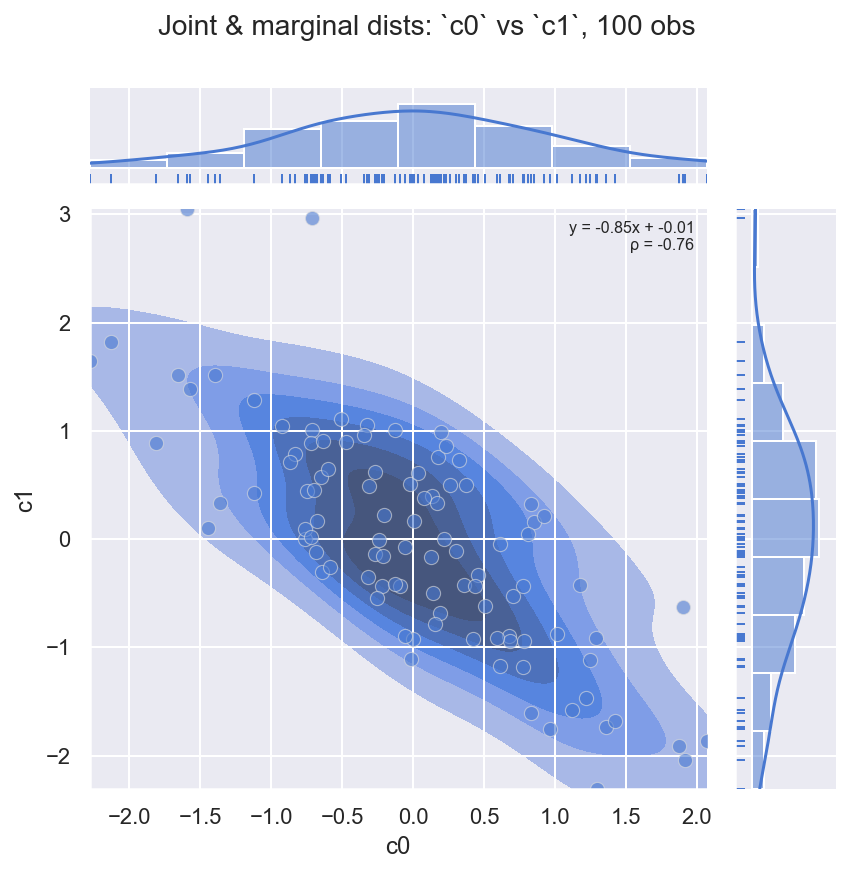

In [8]:
f = eda.plot_joint_numeric(data=df_train, ft0='c0', ft1='c1', kind='kde+scatter', 
            subtitle=f'Latent Copula = $MvN(0, \Sigma={cb.ref_vals["c_cov"].flatten().tolist()})$')

**Observe:**

+ Note the standard `Normal(0,1)` scaling on the marginals
+ Note the empirically-observed $\rho \approx -0.7$ as defined in `c_cov`

### 1.2.2 View the Uniform-Transformed Marginals

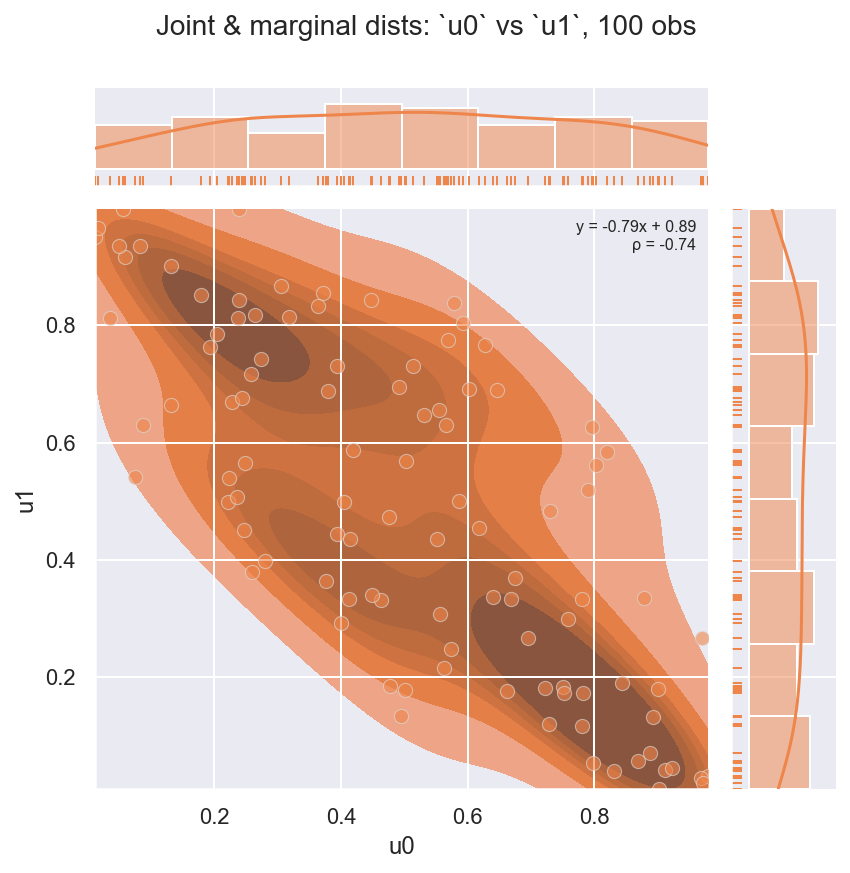

In [9]:
f = eda.plot_joint_numeric(data=df_train, ft0='u0', ft1='u1', kind='kde+scatter', colori=1, 
        subtitle='Latent Uniform Marginals with Copula Correlation')

**Observe:**

+ Now the marginals are uniform, but the correlation remains

### 1.2.3 View the Observed Marginals `m0`, `m1` (post transformation)

**Observe:**

+ This is the only real data that we would observe in the real-world dataset
+ All the above plots are of latent value datapoints
+ We compare this data to the model predictions (in-sample PPC)

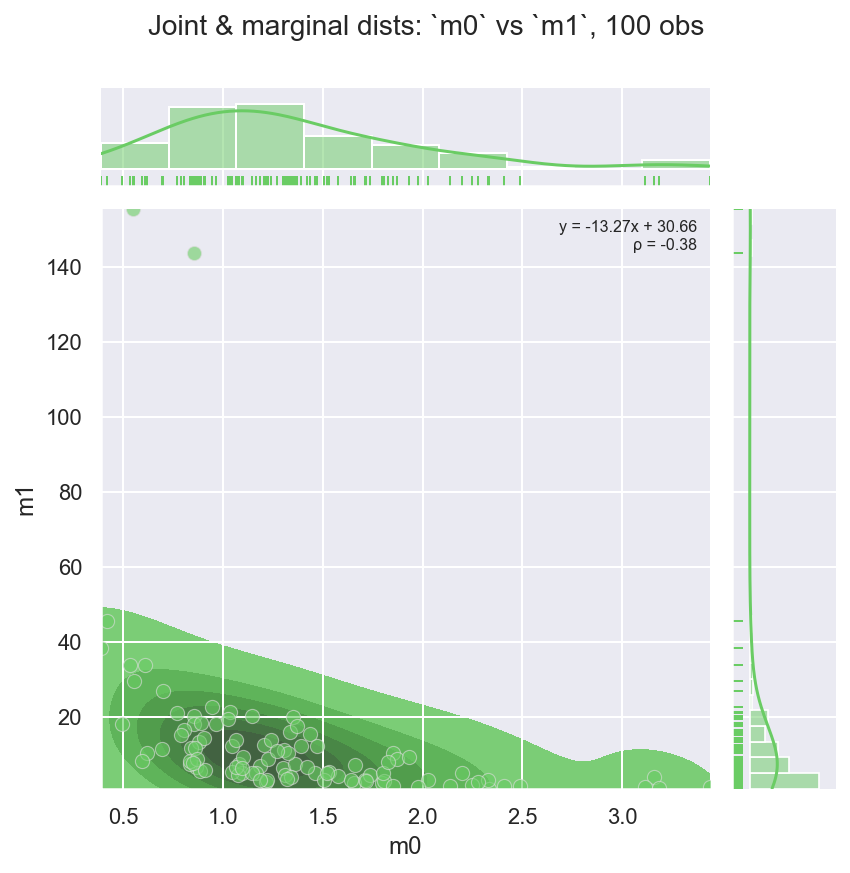

In [10]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0', ft1='m1', kind='kde+scatter', colori=2, 
            subtitle='Observed Marginals with Copula Correlation')

**Observe**

+ Marginals now have unique long-tail distributions
+ The correlation remains

### 1.2.4 View the Uncorrelated marginals `m0x`, `m1x` (ignoring copula)

#### Observed Marginals (uncorrelated)

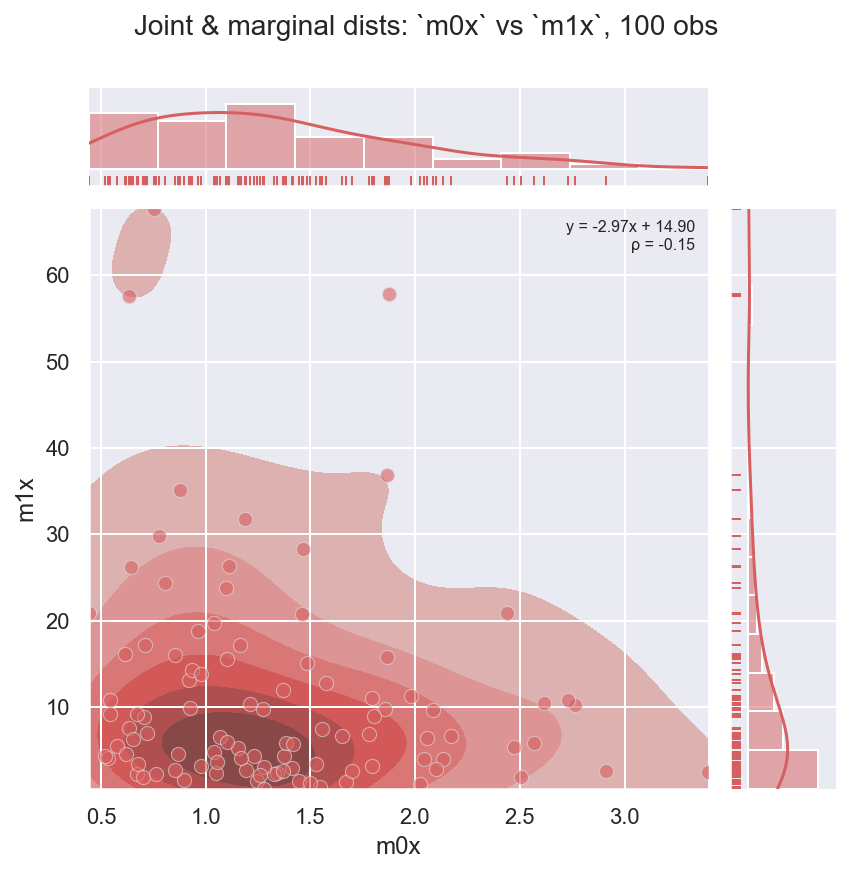

In [11]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0x', ft1='m1x', kind='kde+scatter', colori=3, 
            subtitle='Observed Marginals without Copula Correlation')

**Observe**

+ Spherical joint distribution, no correlation between our marginals here

### 1.2.5 Overplot Correlated and Uncorrelated Marginals to highlight differences

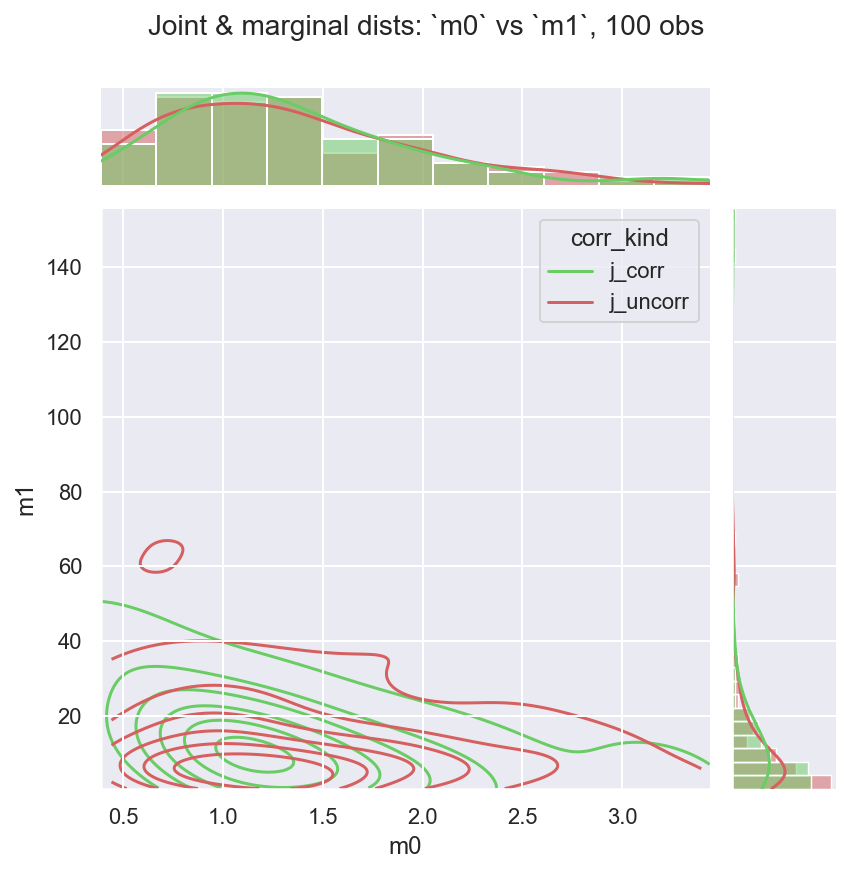

In [12]:
dfp = pd.concat((df_train[['m0', 'm1']], df_train[['m0x', 'm1x']]\
                 .rename(columns={'m0x':'m0', 'm1x': 'm1'})),
                axis=0, ignore_index=True)
dfp['corr_kind'] = np.repeat(['j_corr', 'j_uncorr'], repeats=len(df_train))
f = eda.plot_joint_numeric(
    data=dfp, ft0='m0', ft1='m1', hue='corr_kind', kind='kde', kdefill=False, colori=2,
    subtitle='Observed marginals with / without Copula Correlation')
fqn = figio.write(f, fn='000_jointplot_corr_vs_uncorr')

**Observe**

+ The marginals look almost identical
+ But the joint distribution is very different: correlated green vs spherical (non-corrolated) red
+ This leads to a very different Expected Value

### 1.2.6 Compare the Impact on Joint Distribution

If we fail to model the correlation, the impact on the joint distribution is substantial, and we might easily under/over estimate an Expected value

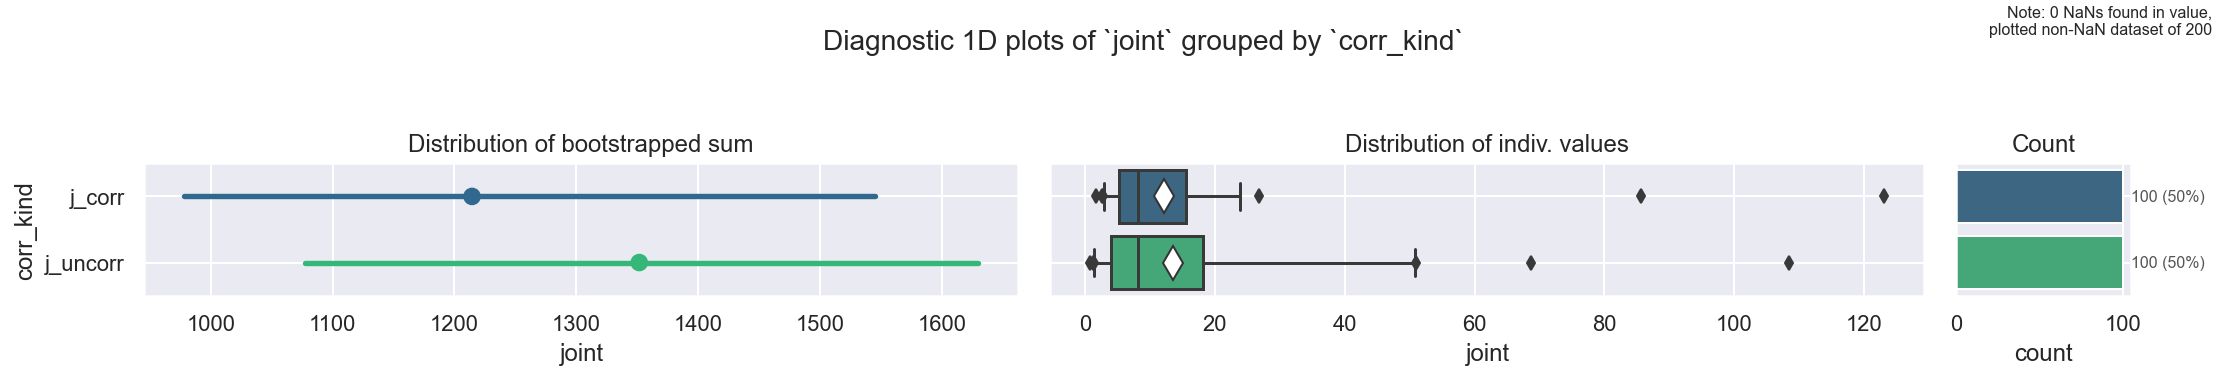

In [13]:
dfp['joint'] = dfp[['m0', 'm1']].product(axis=1)
pal = sns.color_palette(['C2', 'C3'])
f = eda.plot_smrystat_grp(dfp, grp='corr_kind', val='joint', palette=pal)
fqn = figio.write(f, fn='000_eloss_corr_vs_uncorr')

**Observe:**

+ The (bootstrapped) sum of `j_uncorr` ($\mu \approx 1350$) is always much higher than for `j_corr` ($\mu \approx 1200$)
+ This shows that even if we estimated each marginal correctly, if our model were to (erroroneously) ignore the coupled covariance between our marginals `m0`, `m1`, we would (erroneously) overestimate the joint distribution total value

#### View the delta

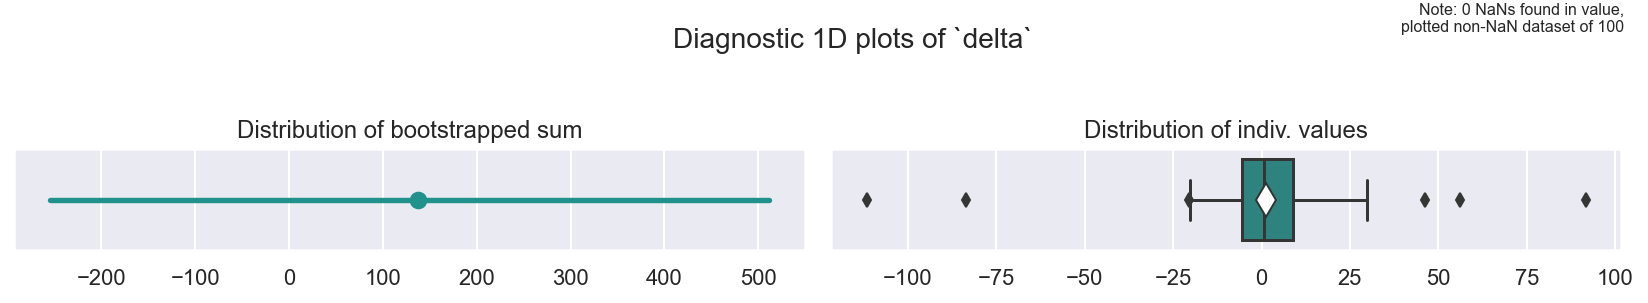

In [14]:
idx = dfp['corr_kind'] == 'j_corr'
dfpp = pd.DataFrame({'delta': dfp.loc[~idx, 'joint'].values - dfp.loc[idx, 'joint'].values}, index=df_train.index)
g = eda.plot_smrystat(dfpp, val='delta', title_add='joint expected value')
fqn = figio.write(f, fn='000_eloss_delta')

**Observe:**

+ Here we view `delta = j_uncorr - j_corr`
+ If we imagine this to be a portfolio of $100$ policies, and the value of interest is an Expected Loss Cost $\mathbb{E}_{loss}$, and the units are dollars, then: 
  + Without the copula, the estimate of $\mathbb{E}_{loss}$ (bootstrapped mean) sum over the portfolio is approx $130$ dollars *higher* than if we use a better model with a copula function
  + This overestimate is a substantial ($\frac{130}{1200} \approx +10\%$) and could make the difference between profitable pricing and accurate reserving, or greatly loss-making business over the portfolio.

---

---

# Notes

In [15]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-27 17:11:14

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

oreum_core: 0.9.9
numpy     : 1.26.4
pandas    : 2.2.3
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
pyprojroot: 0.3.0
seaborn   : 0.12.2



---
**Oreum OÜ &copy; 2024**